In [2]:
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
%matplotlib inline
# Предварительно данные разбиты на 2 .csv файла
# test_SPSS_3.csv - истинные значения до марта 2015, далее пропуски
# test_SPSS_3_pred.csv - истинные значения до сентября 2014, начиная с октября - предсказания Мегафона
# Читаем файл с истинными значениями
data = np.genfromtxt('C:/DATA/Megafon/test_SPSS_3.csv',dtype = [('date','S10'), ('KPI1','float64'), ('KPI2','float64'), 
                                                                ('KPI3','float64'), ('KPI4','float64'), ('KPI5', 'float64')],
                     delimiter = ',', skip_header = 1)
# Читаем файл, содержащий предсказания Мегафона
megafon = np.genfromtxt('C:/DATA/Megafon/test_SPSS_pred.csv',dtype = [('date','S10'), ('KPI1','float64'), ('KPI2','float64'), 
                                                                      ('KPI3','float64'), ('KPI4','float64'), ('KPI5', 'float64')],
                        delimiter = ',', skip_header = 1)
# Задаем конец обучения и теста (значения заданы так, что если x - весь ряд, то x[:train_end] - значения обучающего периода
# x[train_end:test_end] = мзвестные значения тестового
full_len = len(data)
train_end = 84 
test_end = 90

# Извлекаем номера месяцев. Для реализованной здесь модели они не нужны (использовались в первых моделях регрессии)
months = np.array([dt.strptime(data[i][0].decode('utf-8'), '%d.%m.%Y').month for i in range(full_len)])
# Извлекаем значения KPI
KPI = {}
KPI[1] = np.array([data[i][1]/10**6 for i in range(full_len)]) # KPI1 values
KPI[2] = np.array([data[i][2]/10**6 for i in range(full_len)]) # KPI2 values
KPI[3] = np.array([data[i][3]/10**6 for i in range(full_len)]) # KPI3 values
KPI[4] = np.array([data[i][4]/10**6 for i in range(full_len)]) # KPI4 values
KPI[5] = np.array([data[i][5]/10**6 for i in range(full_len)]) # KPI5 values
true_vals = {}
for k in range(1,6):
    true_vals[k] = KPI[k][train_end:test_end].copy()
    KPI[k][train_end:test_end] = np.nan
# Извлекаем значения предсказаний Мегафона
M_KPI = {}
M_KPI[1] = np.array([megafon[i][1]/10**6 for i in range(train_end, full_len)]) # megafon predictions
M_KPI[2] = np.array([megafon[i][2]/10**6 for i in range(train_end, full_len)])
M_KPI[3] = np.array([megafon[i][3]/10**6 for i in range(train_end, full_len)])
M_KPI[4] = np.array([megafon[i][4]/10**6 for i in range(train_end, full_len)])
M_KPI[5] = np.array([megafon[i][5]/10**6 for i in range(train_end, full_len)])

In [3]:
def make_matrix(S, M):
    X = np.empty((S.shape[1]-M, M*S.shape[0]))
    for j in range(S.shape[1]-M):
        for i in range(S.shape[0]):
            X[j,i*M:(i+1)*M] = S[i,j:j+M].T
    return X

def quality(a, y):
    return np.mean(100*np.abs(a - y)/y)

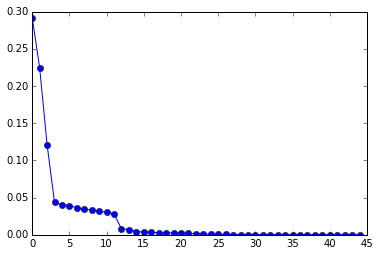

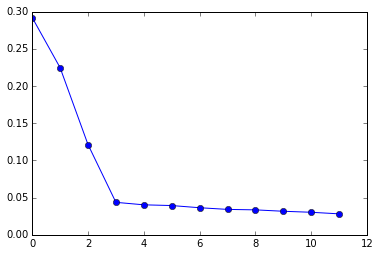

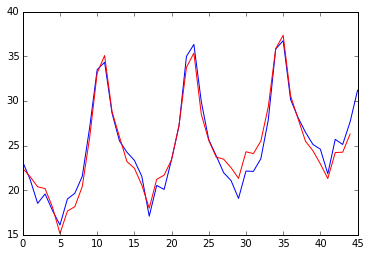

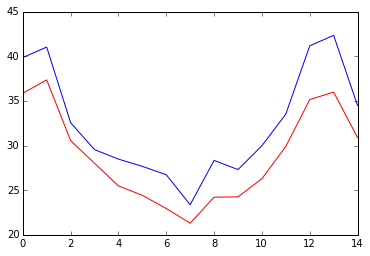

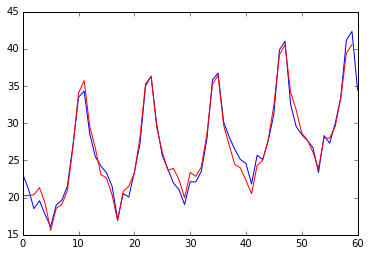

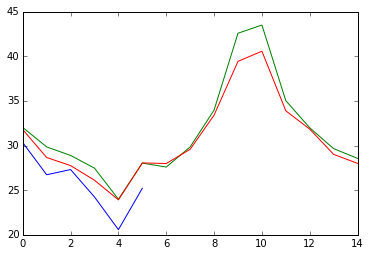

Train_quality: 10.9650620014
Test quality: 8.14364037297
Megafon quality: 10.6844644609


In [4]:
idx = [2,1,3]
S1 = np.empty((len(idx), train_end-(full_len-train_end)))
for k in range(len(idx)):
    S1[k,:] = KPI[idx[k]][:train_end-(full_len-train_end)]
M = 24
X1 = make_matrix(S1, M)
pca = PCA().fit(X1)
plt.figure()
plt.plot(pca.explained_variance_ratio_,'bo-')
plt.show()
plt.figure()
pca_mod = PCA(n_components=12)
pca = pca_mod.fit(X1)
plt.figure()
plt.plot(pca.explained_variance_ratio_,'bo-')
plt.show()
plt.figure()
X1_r = pca.transform(X1)
S2 = S1.copy()
X1_new = pca.inverse_transform(X1_r)
plt.figure()
plt.plot(KPI[2][M-1:train_end-(full_len-train_end)],'b')
plt.plot(X1_new[:,M-1], 'r')
plt.show()
pred = []
for j in range(1, full_len-train_end+1):
    S2[:,:-1] = S2[:,1:]
    S2[:,-1] = X1_new[-1,[k*M-1 for k in range(1,S2.shape[0]+1)]].T
    X2 = make_matrix(S2, M)
    X1_r = pca.transform(X2)
    X1_new = pca.inverse_transform(X1_r)
    pred.append(X1_new[-12, M-1])
plt.figure()
plt.plot(KPI[2][train_end-(full_len-train_end):train_end],'b')
plt.plot(pred, 'r')
plt.show()


S1 = np.empty((len(idx), train_end))
for k in range(len(idx)):
    S1[k,:] = KPI[idx[k]][:train_end]
X1 = make_matrix(S1, M)
pca = pca_mod.fit(X1)
X1_r = pca.transform(X1)
S2 = S1.copy()
X1_new = pca.inverse_transform(X1_r)
plt.figure()
plt.plot(KPI[2][M-1:train_end],'b')
plt.plot(X1_new[:,M-1], 'r')
plt.show()
pred_t = []
for j in range(1, full_len-train_end+1):
    S2[:,:-1] = S2[:,1:]
    S2[:,-1] = X1_new[-1,[k*M-1 for k in range(1,S2.shape[0]+1)]].T
    X2 = make_matrix(S2, M)
    X1_r = pca.transform(X2)
    X1_new = pca.inverse_transform(X1_r)
    pred_t.append(X1_new[-12, M-1])
plt.figure()
plt.plot(true_vals[2],'b')
plt.plot(M_KPI[2],'g')
plt.plot(pred_t, 'r')
plt.show()
print("Train_quality: "+str(quality(pred, KPI[2][train_end-(full_len-train_end):train_end])))
print("Test quality: "+str(quality(pred_t[:test_end-train_end],true_vals[2])))
print("Megafon quality: "+str(quality(M_KPI[2][:test_end-train_end],true_vals[2])))

In [6]:
with open('C:/DATA/Megafon/SVD_123.csv','w') as f:
    f.write('KPI2\n')
    for i in range(full_len-train_end):
        f.write(str(pred_t[i]*10**6)+'\n')
    f.close()

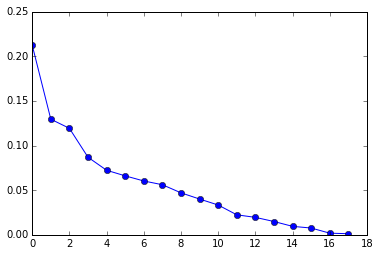

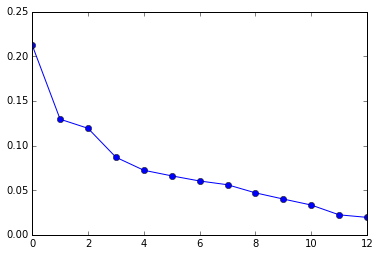

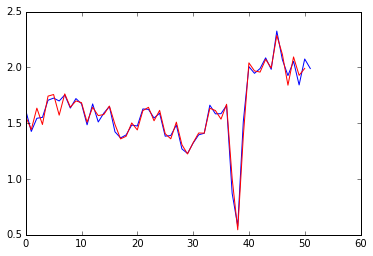

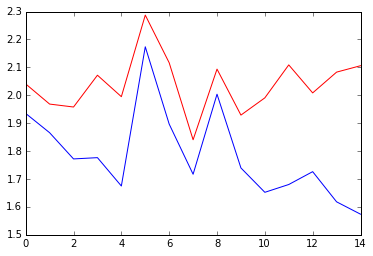

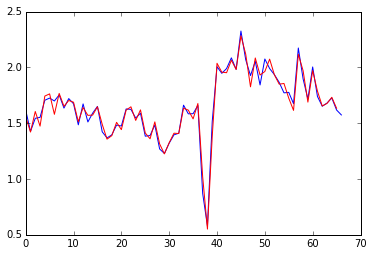

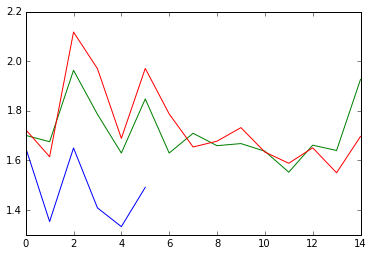

Train_quality: 14.7655704645
Test quality: 25.1329354066
Megafon quality: 19.7918718721


In [403]:
idx = [4]
S1 = np.empty((len(idx), train_end-(full_len-train_end)))
for k in range(len(idx)):
    S1[k,:] = KPI[idx[k]][:train_end-(full_len-train_end)]
M = 18
X1 = make_matrix(S1, M)
pca = PCA().fit(X1)
plt.figure()
plt.plot(pca.explained_variance_ratio_,'bo-')
plt.show()
plt.figure()
pca_mod = PCA(n_components=13)
pca = pca_mod.fit(X1)
plt.figure()
plt.plot(pca.explained_variance_ratio_,'bo-')
plt.show()
plt.figure()
X1_r = pca.transform(X1)
S2 = S1.copy()
X1_new = pca.inverse_transform(X1_r)
plt.figure()
plt.plot(KPI[4][M-1:train_end-(full_len-train_end)],'b')
plt.plot(X1_new[:,M-1], 'r')
plt.show()
pred = []
for j in range(1, full_len-train_end+1):
    S2[:,:-1] = S2[:,1:]
    S2[:,-1] = X1_new[-1,[k*M-1 for k in range(1,S2.shape[0]+1)]].T
    X2 = make_matrix(S2, M)
    X1_r = pca.transform(X2)
    X1_new = pca.inverse_transform(X1_r)
    pred.append(X1_new[-12,M-1])
plt.figure()
plt.plot(KPI[4][train_end-(full_len-train_end):train_end],'b')
plt.plot(pred, 'r')
plt.show()


S1 = np.empty((len(idx), train_end))
for k in range(len(idx)):
    S1[k,:] = KPI[idx[k]][:train_end]
X1 = make_matrix(S1, M)
pca = pca_mod.fit(X1)
X1_r = pca.transform(X1)
S2 = S1.copy()
X1_new = pca.inverse_transform(X1_r)
plt.figure()
plt.plot(KPI[4][M-1:train_end],'b')
plt.plot(X1_new[:,M-1], 'r')
plt.show()
pred_t = []
for j in range(1, full_len-train_end+1):
    S2[:,:-1] = S2[:,1:]
    S2[:,-1] = X1_new[-1,[k*M-1 for k in range(1,S2.shape[0]+1)]].T
    X2 = make_matrix(S2, M)
    X1_r = pca.transform(X2)
    X1_new = pca.inverse_transform(X1_r)
    pred_t.append(X1_new[-12,M-1])
plt.figure()
plt.plot(true_vals[4],'b')
plt.plot(M_KPI[4],'g')
plt.plot(pred_t, 'r')
plt.show()
print("Train_quality: "+str(quality(pred, KPI[4][train_end-(full_len-train_end):train_end])))
print("Test quality: "+str(quality(pred_t[:test_end-train_end],true_vals[4])))
print("Megafon quality: "+str(quality(M_KPI[4][:test_end-train_end],true_vals[4])))